In [3]:
# Install required libraries
!pip install librosa transformers

In [6]:
# Define paths to data
cha_path = '/kaggle/input/PittCombined/cha'
mp3_path = '/kaggle/input/PittCombined/mp3'

In [7]:
# Import necessary libraries
import os
import librosa
import pandas as pd
from transformers import BertTokenizer, BertModel


In [8]:
# List files in directories
cha_files = [os.path.join(cha_path, file) for file in os.listdir(cha_path) if file.endswith('.cha')]
mp3_files = [os.path.join(mp3_path, file) for file in os.listdir(mp3_path) if file.endswith('.mp3')]

print(f"Found {len(cha_files)} CHA files and {len(mp3_files)} MP3 files.")

Found 1255 CHA files and 1253 MP3 files.


In [9]:
import os
import re
import random
from collections import defaultdict, Counter

def extract_diagnosis(cha_file):
    """Extracts the diagnosis from a CHAT transcript file."""
    with open(cha_file, 'r') as file:
        content = file.read()
    match = re.search(r'@ID:\s*[^|]*\|[^|]*\|[^|]*\|[^|]*\|[^|]*\|([^|]*)\|', content)
    return match.group(1) if match else None

# Paths to your CHA and MP3 files
cha_path = '/kaggle/input/PittCombined/cha'
mp3_path = '/kaggle/input/PittCombined/mp3'

# Load all CHA files and their diagnoses
cha_files = [f for f in os.listdir(cha_path) if f.endswith('.cha')]
diagnoses = [extract_diagnosis(os.path.join(cha_path, f)) for f in cha_files]

# Group files by diagnosis, ensuring corresponding MP3 exists
files_by_diagnosis = defaultdict(list)
for cha_file, diag in zip(cha_files, diagnoses):
    mp3_file = cha_file.replace('.cha', '.mp3')
    if os.path.exists(os.path.join(mp3_path, mp3_file)):
        files_by_diagnosis[diag].append(cha_file)

# Select up to 500 files, trying to balance across diagnoses
selected_files = []
for diag, files in files_by_diagnosis.items():
    select_count = min(len(files), max(500 // len(files_by_diagnosis), 1))
    selected_files.extend(random.sample(files, select_count))

# Ensure the selection does not exceed 10 if categories were unbalanced
selected_files = random.sample(selected_files, min(500, len(selected_files)))

# Count of selected diagnoses
selected_diagnoses = [extract_diagnosis(os.path.join(cha_path, f)) for f in selected_files]
diagnosis_count = Counter(selected_diagnoses)

# Find corresponding MP3 files
selected_mp3_files = [f.replace('.cha', '.mp3') for f in selected_files]

# Collect full paths for the selected files
cha_files = [os.path.join(cha_path, f) for f in selected_files]
mp3_files = [os.path.join(mp3_path, f) for f in selected_mp3_files]

# Output results
print("Selected CHA files:", cha_files)
print("Selected MP3 files:", mp3_files)
print("Diagnosis counts:", dict(diagnosis_count))


Selected CHA files: ['/kaggle/input/PittCombined/cha/471-0r.cha', '/kaggle/input/PittCombined/cha/010-0f.cha', '/kaggle/input/PittCombined/cha/476-0s.cha', '/kaggle/input/PittCombined/cha/493-0f.cha', '/kaggle/input/PittCombined/cha/594-0.cha', '/kaggle/input/PittCombined/cha/118-1.cha', '/kaggle/input/PittCombined/cha/707-0.cha', '/kaggle/input/PittCombined/cha/266-2.cha', '/kaggle/input/PittCombined/cha/142-0.cha', '/kaggle/input/PittCombined/cha/468-0f.cha', '/kaggle/input/PittCombined/cha/221-0.cha', '/kaggle/input/PittCombined/cha/046-0.cha', '/kaggle/input/PittCombined/cha/183-1r.cha', '/kaggle/input/PittCombined/cha/325-1r.cha', '/kaggle/input/PittCombined/cha/005-2f.cha', '/kaggle/input/PittCombined/cha/223-1r.cha', '/kaggle/input/PittCombined/cha/492-0s.cha', '/kaggle/input/PittCombined/cha/221-0r.cha', '/kaggle/input/PittCombined/cha/299-1.cha', '/kaggle/input/PittCombined/cha/065-0.cha', '/kaggle/input/PittCombined/cha/704-0s.cha', '/kaggle/input/PittCombined/cha/476-0f.cha'

In [10]:
cha_base_names = set([os.path.splitext(os.path.basename(f))[0] for f in cha_files])
mp3_base_names = set([os.path.splitext(os.path.basename(f))[0] for f in mp3_files])

unmatched_cha = cha_base_names - mp3_base_names
unmatched_mp3 = mp3_base_names - cha_base_names

print("Unmatched CHA files:", unmatched_cha)
print("Unmatched MP3 files:", unmatched_mp3)

Unmatched CHA files: set()
Unmatched MP3 files: set()


In [11]:
import librosa
from transformers import BertTokenizer, BertModel
import soundfile as sf

# Initialize Clinical BERT
tokenizer = BertTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
model = BertModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [12]:
import os
import librosa
import soundfile as sf

def preprocess_audio(mp3_file_path, output_wav_path):
    # Define output path within the writable directory
    output_wav_path = os.path.join('/kaggle/working', os.path.basename(output_wav_path))

    try:
        # Check if the WAV file already exists
        if not os.path.exists(output_wav_path):
            # Convert MP3 to WAV
            y, sr = librosa.load(mp3_file_path, sr=None)
            sf.write(output_wav_path, y, sr)
            print(f"Converted {mp3_file_path} to WAV.")
        else:
            print(f"WAV file already exists: {output_wav_path}")

        # Extract MFCC features
        y, sr = librosa.load(output_wav_path, sr=None)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        return mfccs.mean(axis=1)
    except Exception as e:
        print(f"An error occurred while processing {mp3_file_path}: {str(e)}")
        return None

# Replace 'mp3_files' with the actual list of mp3 file paths
audio_features = [preprocess_audio(f, f.replace('.mp3', '.wav')) for f in mp3_files if f.endswith('.mp3')]


Converted /kaggle/input/PittCombined/mp3/471-0r.mp3 to WAV.
Converted /kaggle/input/PittCombined/mp3/010-0f.mp3 to WAV.
Converted /kaggle/input/PittCombined/mp3/476-0s.mp3 to WAV.
Converted /kaggle/input/PittCombined/mp3/493-0f.mp3 to WAV.
Converted /kaggle/input/PittCombined/mp3/594-0.mp3 to WAV.
Converted /kaggle/input/PittCombined/mp3/118-1.mp3 to WAV.
Converted /kaggle/input/PittCombined/mp3/707-0.mp3 to WAV.
Converted /kaggle/input/PittCombined/mp3/266-2.mp3 to WAV.
Converted /kaggle/input/PittCombined/mp3/142-0.mp3 to WAV.
Converted /kaggle/input/PittCombined/mp3/468-0f.mp3 to WAV.
Converted /kaggle/input/PittCombined/mp3/221-0.mp3 to WAV.
Converted /kaggle/input/PittCombined/mp3/046-0.mp3 to WAV.
Converted /kaggle/input/PittCombined/mp3/183-1r.mp3 to WAV.
Converted /kaggle/input/PittCombined/mp3/325-1r.mp3 to WAV.
Converted /kaggle/input/PittCombined/mp3/005-2f.mp3 to WAV.
Converted /kaggle/input/PittCombined/mp3/223-1r.mp3 to WAV.
Converted /kaggle/input/PittCombined/mp3/492-0s

In [13]:
# Define a function to preprocess text data
def preprocess_text(file_path):
    with open(file_path, 'r') as file:
        text = file.read()
    # Insert text cleaning code here as necessary
    inputs = tokenizer(text, return_tensors="pt", max_length=512, truncation=True, padding="max_length")
    outputs = model(**inputs)
    return outputs.last_hidden_state.squeeze().detach().numpy()

In [14]:
print(cha_files)

['/kaggle/input/PittCombined/cha/471-0r.cha', '/kaggle/input/PittCombined/cha/010-0f.cha', '/kaggle/input/PittCombined/cha/476-0s.cha', '/kaggle/input/PittCombined/cha/493-0f.cha', '/kaggle/input/PittCombined/cha/594-0.cha', '/kaggle/input/PittCombined/cha/118-1.cha', '/kaggle/input/PittCombined/cha/707-0.cha', '/kaggle/input/PittCombined/cha/266-2.cha', '/kaggle/input/PittCombined/cha/142-0.cha', '/kaggle/input/PittCombined/cha/468-0f.cha', '/kaggle/input/PittCombined/cha/221-0.cha', '/kaggle/input/PittCombined/cha/046-0.cha', '/kaggle/input/PittCombined/cha/183-1r.cha', '/kaggle/input/PittCombined/cha/325-1r.cha', '/kaggle/input/PittCombined/cha/005-2f.cha', '/kaggle/input/PittCombined/cha/223-1r.cha', '/kaggle/input/PittCombined/cha/492-0s.cha', '/kaggle/input/PittCombined/cha/221-0r.cha', '/kaggle/input/PittCombined/cha/299-1.cha', '/kaggle/input/PittCombined/cha/065-0.cha', '/kaggle/input/PittCombined/cha/704-0s.cha', '/kaggle/input/PittCombined/cha/476-0f.cha', '/kaggle/input/Pit

In [15]:
# Process each file
text_embeddings = [preprocess_text(f) for f in cha_files]

In [16]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming text_embeddings and audio_features are lists of numpy arrays
# Convert lists to numpy arrays
text_features = np.array(text_embeddings)
audio_features = np.stack(audio_features)

In [17]:
print(text_features)

[[[ 1.09979533e-01  2.99312711e-01 -7.80567884e-01 ...  3.62643272e-01
    1.16972551e-01 -3.19270184e-03]
  [-4.71796006e-01  2.06041470e-01  2.10394943e-03 ...  8.95473212e-02
    4.42636013e-01 -3.38241279e-01]
  [ 2.69378722e-01 -2.33631298e-01  4.96399432e-01 ...  7.95971215e-01
   -3.33011121e-01  2.91673273e-01]
  ...
  [ 1.16520356e-02  1.05107119e-02 -3.60428214e-01 ...  3.13008845e-01
   -2.48271506e-02 -1.55104235e-01]
  [-8.10841285e-03  1.00540623e-01 -2.21159682e-01 ...  2.22374842e-01
    2.69428402e-01  3.30544040e-02]
  [-3.67280453e-01  5.19466549e-02 -1.36770204e-01 ...  2.20021591e-01
   -2.56141759e-02  2.93723851e-01]]

 [[-7.85723180e-02  2.16493569e-02 -5.58685243e-01 ...  3.84697825e-01
   -2.05540843e-02 -4.19983342e-02]
  [-4.70374137e-01  3.62167209e-01  2.89309293e-01 ... -1.41350314e-01
    5.24703324e-01 -4.33563620e-01]
  [ 3.12414970e-02  5.13816141e-02  4.79679286e-01 ...  5.42087436e-01
   -5.60825706e-01  3.31900299e-01]
  ...
  [-2.12872177e-01  7.6

In [18]:
print(audio_features)

[[-4.2639081e+02  6.5972229e+01  2.3582987e+01 ... -3.4135962e-01
   9.6120149e-02  3.9023079e-02]
 [-4.6498120e+02  1.0240597e+02 -1.3534848e-01 ... -5.9315195e+00
   4.6150336e+00 -2.5880613e+00]
 [-4.1611035e+02  1.3263930e+02  3.3089481e+01 ...  4.6662607e+00
   4.5605416e+00  2.5933096e+00]
 ...
 [-3.6486887e+02  1.5574690e+02  4.3164127e+01 ... -2.7687421e-01
   8.4548831e-01  8.6200994e-01]
 [-5.3747296e+02  7.9762901e+01  5.6201029e+00 ... -1.1798404e+00
   2.5708537e+00  3.8758621e-01]
 [-5.7707629e+02  7.5011490e+01  2.5930180e+01 ... -8.5799605e-02
   2.1946554e+00 -9.4750029e-01]]


In [19]:
text_features = np.mean(text_features, axis=1)


In [20]:
print(text_features)

[[-0.02843789 -0.03070695 -0.22625044 ...  0.30806404  0.22909185
  -0.08626045]
 [-0.04740243 -0.2801818  -0.06755839 ...  0.0492389  -0.00313381
  -0.05508307]
 [-0.11139227 -0.3305669  -0.15961027 ... -0.00471439  0.0919053
  -0.03640968]
 ...
 [-0.15453936 -0.3558479  -0.20345756 ...  0.01935033  0.07947309
  -0.06541515]
 [-0.1570292  -0.24192101 -0.22488531 ... -0.00690853  0.0365301
  -0.08216862]
 [-0.09219684 -0.263291   -0.28250697 ...  0.21326967 -0.04500723
  -0.09974168]]


In [21]:
# Ensure audio_features is 2D
if audio_features.ndim > 2:
    audio_features = np.mean(audio_features, axis=1)

In [22]:
# Combine text and audio features
combined_features = np.concatenate([text_features, audio_features], axis=1)

In [23]:
print(combined_features)

[[-0.02843789 -0.03070695 -0.22625044 ... -0.34135962  0.09612015
   0.03902308]
 [-0.04740243 -0.2801818  -0.06755839 ... -5.9315195   4.6150336
  -2.5880613 ]
 [-0.11139227 -0.3305669  -0.15961027 ...  4.6662607   4.5605416
   2.5933096 ]
 ...
 [-0.15453936 -0.3558479  -0.20345756 ... -0.2768742   0.8454883
   0.86200994]
 [-0.1570292  -0.24192101 -0.22488531 ... -1.1798404   2.5708537
   0.3875862 ]
 [-0.09219684 -0.263291   -0.28250697 ... -0.0857996   2.1946554
  -0.9475003 ]]


In [24]:
# Normalize the combined features
scaler = StandardScaler()
normalized_features = scaler.fit_transform(combined_features)

In [25]:
import re

def extract_diagnostic_code(cha_file):
    # Read the content of the .cha file
    with open(cha_file, 'r') as file:
        content = file.read()

    # Regex to find the diagnosis in the file content based on the updated structure
    match = re.search(r'@ID:\s*[^|]*\|[^|]*\|[^|]*\|[^|]*\|[^|]*\|([^|]*)\|\|', content)
    if match:
        return match.group(1).strip()
    return None

labels = [extract_diagnostic_code(f) for f in cha_files]

# Example of how you might use this
for label in labels[:10]:  # Print first 10 labels to verify
    print(label)


PossibleAD
ProbableAD
PossibleAD
ProbableAD
MCI
Control
PossibleAD
Control
Control
Vascular


In [26]:
from sklearn.preprocessing import LabelEncoder

# Encode labels as integers
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)


In [27]:
print(encoded_labels)

[5 7 5 7 2 0 5 0 0 8 2 7 7 7 7 8 7 2 0 2 4 5 5 0 7 5 5 2 8 5 2 3 7 0 2 7 2
 6 7 0 2 5 2 0 2 3 5 5 0 0 0 0 5 7 0 2 2 0 5 7 0 0 5 5 0 4 2 5 0 2 0 2 0 5
 7 7 0 3 8 3 5 2 5 5 5 2 0 0 2 8 8 0 6 7 7 7 7 8 3 2 0 2 2 5 0 5 3 7 0 3 7
 8 5 5 5 7 2 8 8 5 5 7 2 3 7 0 0 5 2 5 7 0 3 7 0 7 0 5 0 0 5 2 2 5 0 5 2 0
 0 7 2 7 0 8 7 2 2 0 5 7 7 7 2 2 0 2 5 2 2 7 2 7 2 5 5 0 2 2 2 3 8 8 7 2 0
 7 4 7 5 2 5 2 7 7 0 7 5 8 5 0 6 3 7 5 0 5 2 2 2 8 2 3 8 0 2 0 4 7 0 8 0 2
 5 5 2 5 0 7 7 7 5 2 1 7 0 2 0 7 5 7 7 0 7 5 7 0 5 6 0 5 5 7 2 7 5 7 8 5 2
 8]


In [28]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, Conv1D, GlobalAveragePooling1D, BatchNormalization
from tensorflow.keras.optimizers import Adam

2024-08-20 23:08:42.625303: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-20 23:08:42.625465: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-20 23:08:42.777868: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [29]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler

In [30]:
# Split data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(normalized_features, encoded_labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Finding the maximum label value across all datasets to ensure consistency
max_label = max(np.max(y_train), np.max(y_val), np.max(y_test)) + 1  # Plus one because classes are zero-indexed

# One-hot encode the labels with a consistent number of classes across datasets
y_train = to_categorical(y_train, num_classes=max_label)
y_val = to_categorical(y_val, num_classes=max_label)
y_test = to_categorical(y_test, num_classes=max_label)




In [31]:
print("y_test",y_test)

y_test [[0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1

In [32]:
from tensorflow.keras.regularizers import l2

# Model architecture
input_text = Input(shape=(768,))  # Text features from Clinical BERT
input_audio = Input(shape=(13,))  # Audio features, assuming MFCCs with 13 coefficients

# Text pathway
text_dense = Dense(128, activation='relu', kernel_regularizer=l2(0.1))(input_text)
text_bn = BatchNormalization()(text_dense)  # Add batch normalization
text_out = Dropout(0.3)(text_bn)  # Increase dropout rate


In [33]:
from tensorflow.keras.layers import Reshape

# Audio pathway
audio_reshape = Reshape((13, 1))(input_audio)
conv1 = Conv1D(64, kernel_size=3, activation='relu', kernel_regularizer=l2(0.1))(audio_reshape)
conv1_bn = BatchNormalization()(conv1)
conv1_pool = GlobalAveragePooling1D()(conv1_bn)
audio_out = Dropout(0.3)(conv1_pool)  # Increase dropout rate

In [34]:
# Fusion and output
concatenated = Concatenate()([text_out, audio_out])
dense_layer = Dense(64, activation='relu', kernel_regularizer=l2(0.1))(concatenated)  # Regularize dense layer

# Assuming y_train has already been one-hot encoded correctly
num_classes = y_train.shape[1]

# Adjust your output layer
output_layer = Dense(num_classes, activation='softmax')(dense_layer)


In [35]:
print(concatenated)

<KerasTensor shape=(None, 192), dtype=float32, sparse=False, name=keras_tensor_10>


In [36]:
from tensorflow.keras.metrics import Precision, Recall

# Compile model
model = Model(inputs=[input_text, input_audio], outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])


In [37]:
# Fit model on training data
history = model.fit([X_train[:, :768], X_train[:, 768:]], y_train, validation_data=([X_val[:, :768], X_val[:, 768:]], y_val), epochs=100, batch_size=32)


Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 0.1009 - loss: 33.5868 - precision: 0.0907 - recall: 0.0078 - val_accuracy: 0.2115 - val_loss: 30.9304 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3172 - loss: 30.0887 - precision: 0.3131 - recall: 0.0474 - val_accuracy: 0.3077 - val_loss: 27.9771 - val_precision: 0.5000 - val_recall: 0.0577
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4602 - loss: 27.0450 - precision: 0.5730 - recall: 0.1826 - val_accuracy: 0.3654 - val_loss: 25.2176 - val_precision: 0.4444 - val_recall: 0.0769
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5394 - loss: 24.1105 - precision: 0.7142 - recall: 0.2579 - val_accuracy: 0.3846 - val_loss: 22.6255 - val_precision: 0.5455 - val_recall: 0.1154
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6040 - loss: 21.5217 - precision: 0.7772 - recall: 0.2802 - val_accuracy: 0.4231 - val_

In [38]:
# Evaluate the model on the test set
evaluation = model.evaluate([X_test[:, :768], X_test[:, 768:]], y_test)
print(f'Accuracy: {evaluation[1]*100:.2f}%, Precision: {evaluation[2]*100:.2f}%, Recall: {evaluation[3]*100:.2f}%')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3966 - loss: 2.4694 - precision: 0.4076 - recall: 0.2628 
Accuracy: 42.31%, Precision: 43.75%, Recall: 26.92%


In [39]:
history.history

{'accuracy': [0.12820513546466827,
  0.3461538553237915,
  0.48076921701431274,
  0.5192307829856873,
  0.6089743375778198,
  0.6730769276618958,
  0.6858974099159241,
  0.7243589758872986,
  0.7756410241127014,
  0.8525640964508057,
  0.8589743375778198,
  0.8589743375778198,
  0.8782051205635071,
  0.9166666865348816,
  0.8910256624221802,
  0.8974359035491943,
  0.942307710647583,
  0.9230769276618958,
  0.942307710647583,
  0.9487179517745972,
  0.9679487347602844,
  0.942307710647583,
  0.9487179517745972,
  0.9551281929016113,
  0.9487179517745972,
  0.9615384340286255,
  0.9679487347602844,
  0.9294871687889099,
  0.9358974099159241,
  0.9294871687889099,
  0.9679487347602844,
  0.9487179517745972,
  0.9679487347602844,
  0.9487179517745972,
  0.9679487347602844,
  0.9551281929016113,
  0.9551281929016113,
  0.9615384340286255,
  0.9679487347602844,
  0.9743589758872986,
  0.9487179517745972,
  0.942307710647583,
  0.9166666865348816,
  0.9358974099159241,
  0.9358974099159241,


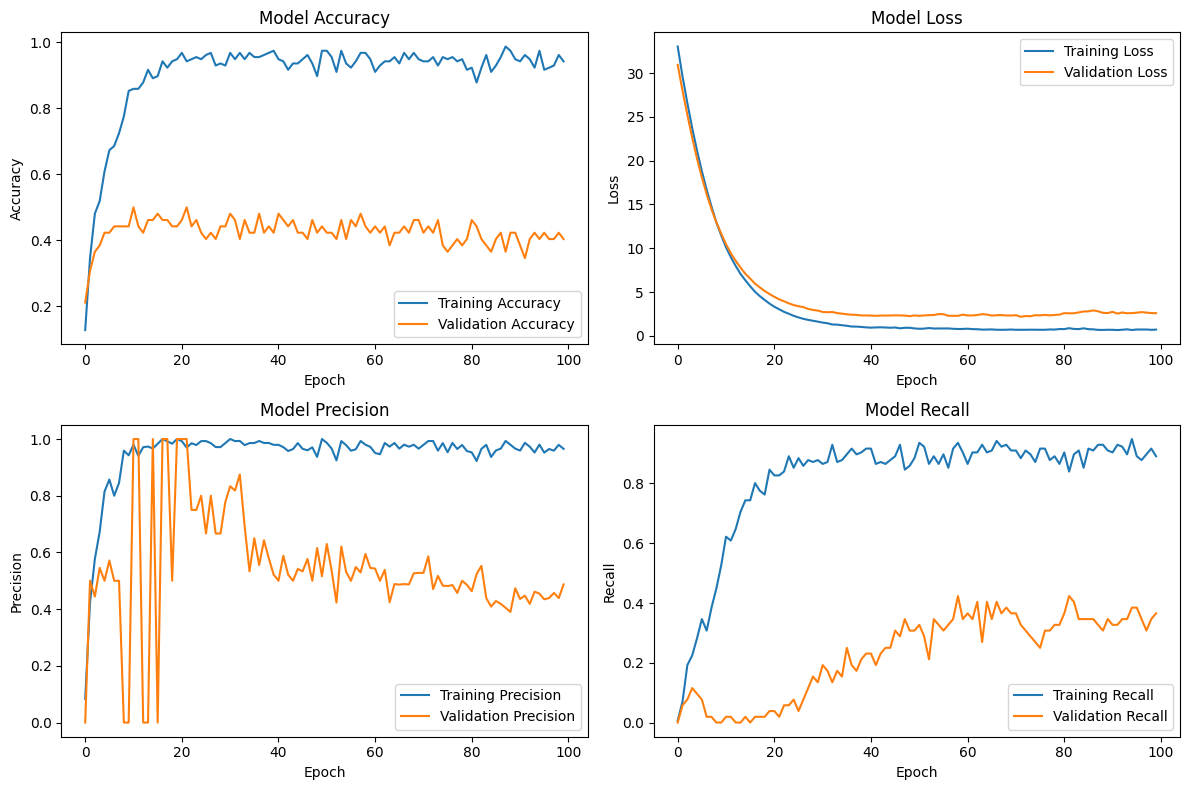

In [40]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Plotting accuracy
    plt.figure(figsize=(12, 8))

    # Accuracy
    plt.subplot(2, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(2, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Precision
    plt.subplot(2, 2, 3)
    plt.plot(history.history['precision'], label='Training Precision')
    plt.plot(history.history['val_precision'], label='Validation Precision')
    plt.title('Model Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.legend()

    # Recall
    plt.subplot(2, 2, 4)
    plt.plot(history.history['recall'], label='Training Recall')
    plt.plot(history.history['val_recall'], label='Validation Recall')
    plt.title('Model Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot the training history
plot_training_history(history)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


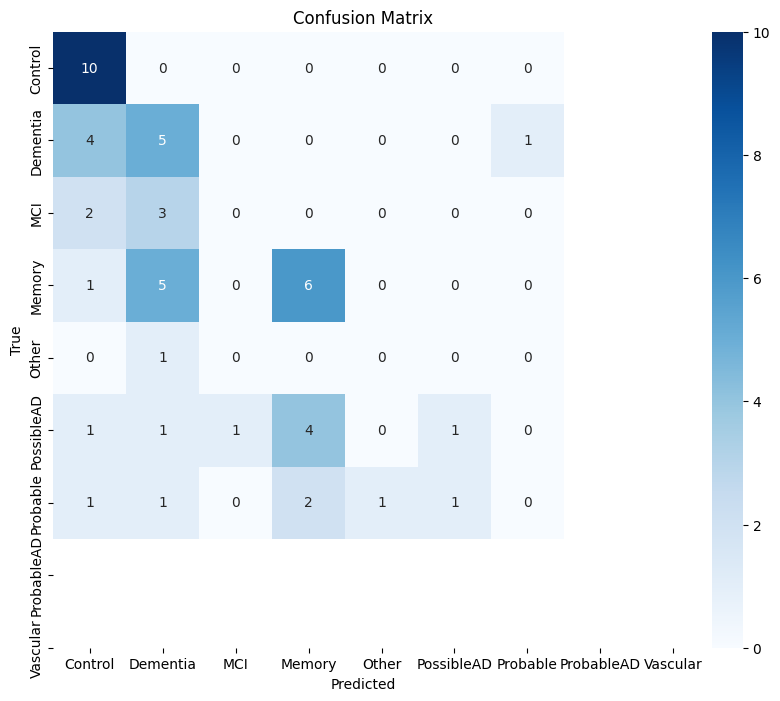

In [41]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming 'y_test' are the true labels and 'predicted_classes' are the predicted labels
predictions = model.predict([X_test[:, :768], X_test[:, 768:]])
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

def plot_confusion_matrix(true_classes, predicted_classes, class_names):
    cm = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Example usage:
class_names = label_encoder.classes_  # Assuming you used a label encoder for your classes
plot_confusion_matrix(true_classes, predicted_classes, class_names)


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


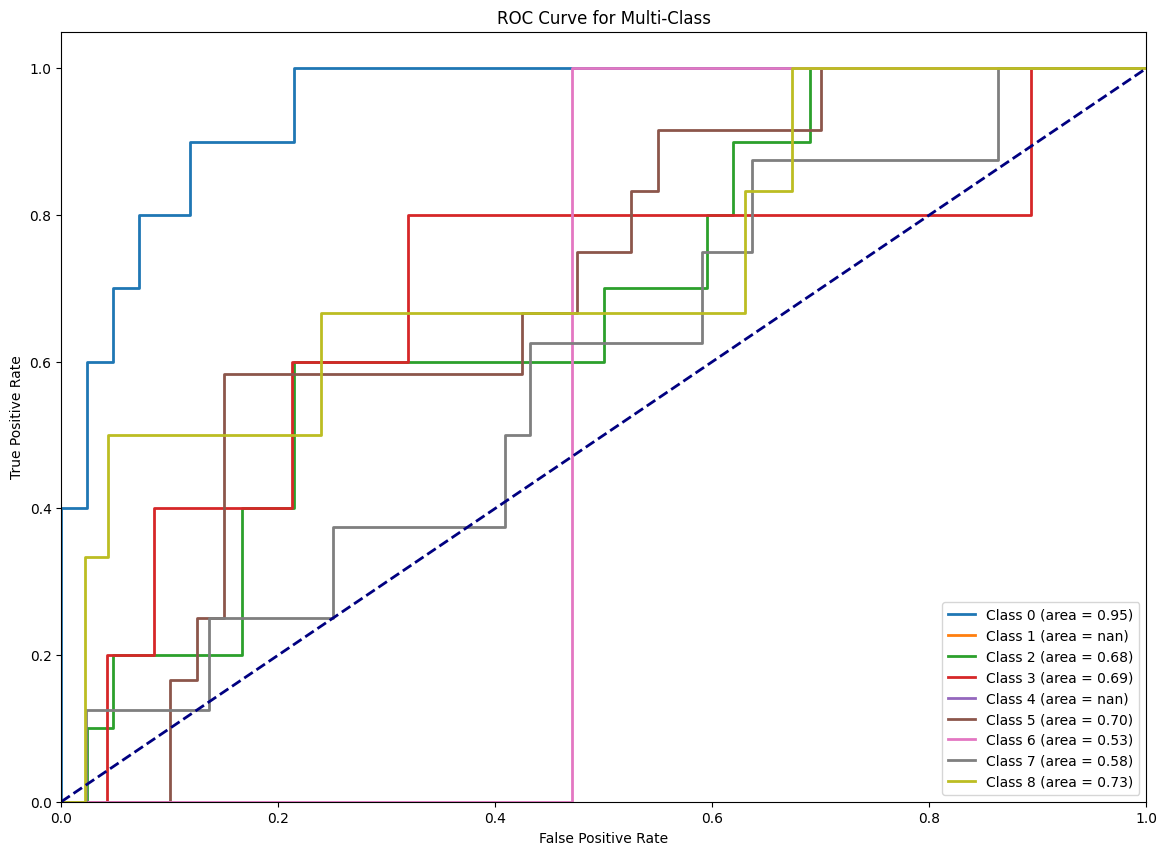

In [42]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the labels for multi-class ROC curve
y_test_binarized = label_binarize(y_test, classes=np.arange(len(class_names)))

def plot_roc_curves(y_test_binarized, predictions, num_classes):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    plt.figure(figsize=(14, 10))
    
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], predictions[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multi-Class')
    plt.legend(loc="lower right")
    plt.show()

# Example usage:
plot_roc_curves(y_test_binarized, predictions, len(class_names))


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


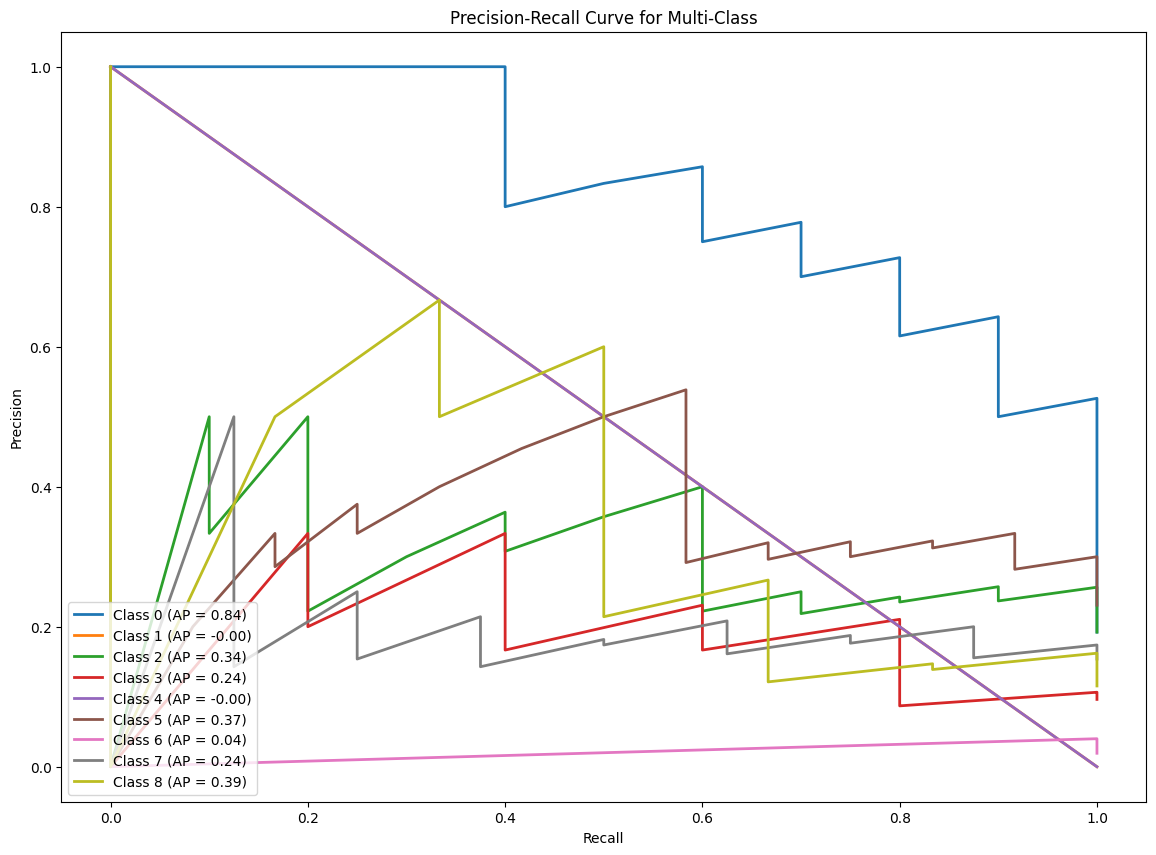

In [43]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

def plot_precision_recall_curves(y_test_binarized, predictions, num_classes):
    plt.figure(figsize=(14, 10))
    
    for i in range(num_classes):
        precision, recall, _ = precision_recall_curve(y_test_binarized[:, i], predictions[:, i])
        average_precision = average_precision_score(y_test_binarized[:, i], predictions[:, i])
        plt.plot(recall, precision, lw=2, label=f'Class {i} (AP = {average_precision:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Multi-Class')
    plt.legend(loc="lower left")
    plt.show()

# Example usage:
plot_precision_recall_curves(y_test_binarized, predictions, len(class_names))
